In [1]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import math

In [2]:
# Fetch historical stock data using yfinance
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [3]:
# Fetch data for Apple stock
data = fetch_data('AAPL', '2015-01-01', '2022-12-31')

[*********************100%***********************]  1 of 1 completed


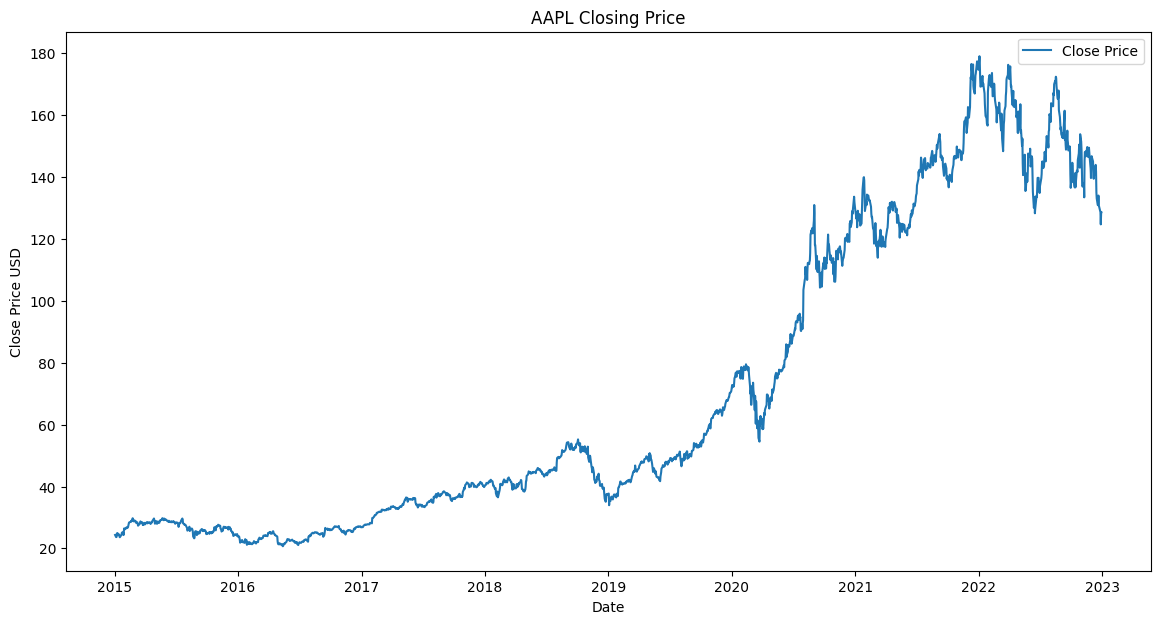

In [4]:
# Visualize the closing price
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.title('AAPL Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

In [5]:
# Prepare data for LSTM model
# Select the 'Close' column for modeling
closing_prices = data['Close'].values.reshape(-1, 1)

In [6]:
# Normalize the data to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

In [7]:
# Split data into training and testing sets
train_size = int(len(closing_prices) * 0.8)  # Use 80% of data for training
test_size = len(closing_prices) - train_size
train_data, test_data = closing_prices[:train_size], closing_prices[train_size:]
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [8]:
# Function to create dataset with features and labels
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [9]:
# Create datasets for training and testing
time_step = 50
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [11]:
# Build the LSTM model
model = Sequential([
    Input(shape=(time_step, 1)),  # Explicitly define the input shape
    LSTM(50, return_sequences=True),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=50, verbose=1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0424
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0017
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 6.4301e-04
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.1531e-04
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.0579e-04
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.5196e-04
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.1951e-04
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7103e-04
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.9579e-04
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3242e-04
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.8026e-04
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.2490e-04
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 3.8671e-04
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7453e-04
Epoch 15/50
25/25 ━━━━━

In [14]:
# Predict using the model
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step  
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [15]:
# Inverse transform the predictions to original scale
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
y_train_original = scaler.inverse_transform(y_train.reshape(-1, 1))

In [16]:
# Same for test data
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

In [17]:
# Evaluate the model using RMSE
train_rmse = math.sqrt(mean_squared_error(y_train_original, train_predictions))
test_rmse = math.sqrt(mean_squared_error(y_test_original, test_predictions))

In [18]:
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

Training RMSE: 1.82
Testing RMSE: 4.66


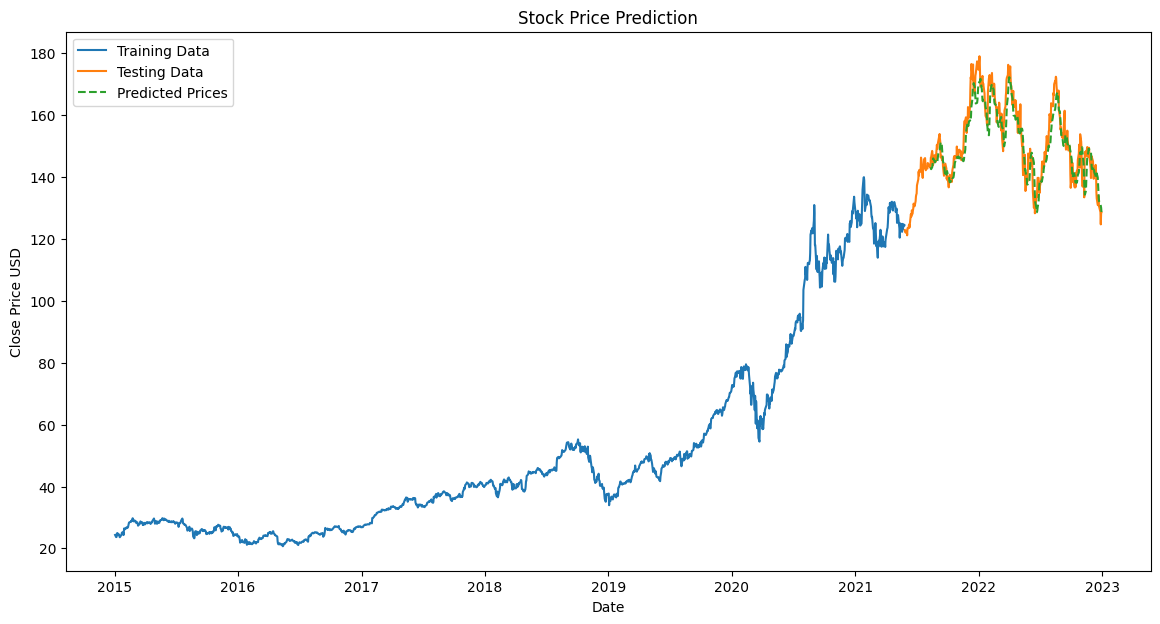

In [19]:
# Visualize the predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index[:train_size], scaler.inverse_transform(train_data), label='Training Data')
plt.plot(data.index[train_size:], scaler.inverse_transform(test_data), label='Testing Data')
plt.plot(data.index[train_size + time_step + 1:], test_predictions, label='Predicted Prices', linestyle='--')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.legend()
plt.show()

This project implements a Long Short-Term Memory (LSTM) model to predict stock prices using historical data.
Key steps:
1. Fetch stock data using the yfinance library.
2. Preprocess data by normalizing it and creating sequences of time steps.
3. Build an LSTM model with TensorFlow/Keras.
4. Train the model and evaluate its performance using RMSE on training and test datasets.
5. Visualize the results, comparing true stock prices with predicted prices.
